In [44]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

from tqdm import tqdm

In [ ]:
def get_trunk():
    
    trunk = np.zeros(())

In [108]:
class Rockne_FDM:

    dx: float
    dt: float
    lb: float

    s: callable
    alpha: float
    alpha_beta: float

    def __init__(self, l: int, tf: int, d: float, p: float, alpha: float, alpha_beta: float, size_dom: int):

        self.l = l
        self.tf = tf
        self.d = d
        self.p = p
        self.size_dom = size_dom

        x = np.linspace(0, 1, size_dom, dtype=np.float32)
        t = np.linspace(0, tf * p, tf, dtype=np.float32)

        self.dx = x[1]
        self.dt = t[1]
        self.lb = (d * self.dt) / (p * l**2 * self.dx**2)

        self.s = lambda d, a, ab: np.exp(-a * (d + (d**2 / ab)))
        self.alpha = alpha 
        self.alpha_beta = alpha_beta

    def MLQ(self, d: float) -> float:

        if d == 0: return -1 
        return -1 + (1 - self.s(d, self.alpha, self.alpha_beta)) / self.p

    def __call__(self, x: np.ndarray, d: float = -1.0) -> np.ndarray:

        a = np.zeros((self.size_dom, self.size_dom))
        b = np.zeros((self.size_dom, self.size_dom))
        gamma_a = 1. + 0.5 * self.dt * self.MLQ(d) + self.lb
        gamma_b = 1. - 0.5 * self.dt * self.MLQ(d) - self.lb

        a[0,0], a[-1, -1] = -3 / (4 * self.dx), 3 / (4 * self.dx)
        a[0,1], a[-1, -2] =  1 / (self.dx), -1 / (self.dx)
        a[0,2], a[-1, -3] = -1 / (4 * self.dx), 1 / (4 * self.dx)

        b[0,0], b[-1, -1] =  3 / (4 * self.dx), -3 / (4 * self.dx)
        b[0,1], b[-1, -2] = -1 / (self.dx), 1 / (self.dx)
        b[0,2], b[-1, -3] =  1 / (4 * self.dx), -1 / (4 * self.dx)

        for i in range(1, self.size_dom - 1):
            a[i,i], b[i,i] = gamma_a, gamma_b
            a[i,i+1], b[i,i+1] = -0.5 * self.lb, 0.5 * self.lb
            a[i,i-1], b[i,i-1] = -0.5 * self.lb, 0.5 * self.lb

        dir = b @ x
        esq = np.linalg.solve(a, dir)
        return esq

class Database:

    branch: np.array 
    trunk: np.array
    target: np.array   

    def __init__(self):

        self.branch = None
        self.trunk = None
        self.target = None     

    def generate_initial_conditions(self, data_size: int, lenght_size: int, variancia: float = 1.0, correlacao: float = 0.1):

        initial_conditions = np.zeros((data_size, lenght_size))
        x = np.linspace(0, 1, lenght_size)
        for i in range(data_size):

            model = gs.Gaussian(dim=1, var=variancia, len_scale=correlacao)
            srf = gs.SRF(model)
            initial_conditions[i] = srf(x)

        return initial_conditions
    
    def generate_data(self, data_size: int, lenght_size: float, time_size: int):

        branch = np.zeros((data_size, 100), dtype = np.float32)
        initial_conditions = self.generate_initial_conditions(data_size, lenght_size)
        for i in range(data_size): branch[i] = initial_conditions[i][::5]
        self.branch = branch

        x = np.linspace(0, 20, lenght_size)
        t = np.arange(0, time_size, 1.0)
        trunk = np.zeros((lenght_size * time_size, 2), dtype = np.float32)
        for i in range(time_size):
            for j in range(lenght_size):
                trunk[i * lenght_size + j] = [t[i], x[j]]

        self.trunk = trunk

        target = np.zeros((data_size, time_size * lenght_size), dtype = np.float32)
        for i in tqdm(range(data_size)):
            
            result = np.zeros((time_size, lenght_size))
            model = Rockne_FDM(20, time_size, 0.0039, 0.0453, 0.0305, 10., lenght_size)
            result[0] = initial_conditions[i]
            for j in range(1, time_size): result[j] = model(result[j-1])
            target[i] = result.flatten()

        self.target = target

    def save(self, local):

        with open(local, 'wb') as f:

            np.save(f, self.branch)
            np.save(f, self.trunk)
            np.save(f, self.target)

In [109]:
database = Database()

database.generate_data(10, 500, 80)

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


In [110]:
branch = database.branch
target = database.target 

target = target.reshape((10, 80, 500))

In [116]:
branch.shape

(10, 100)

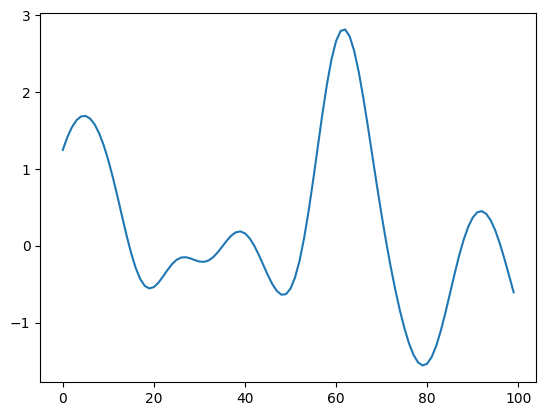

In [111]:
plt.plot(branch[2])

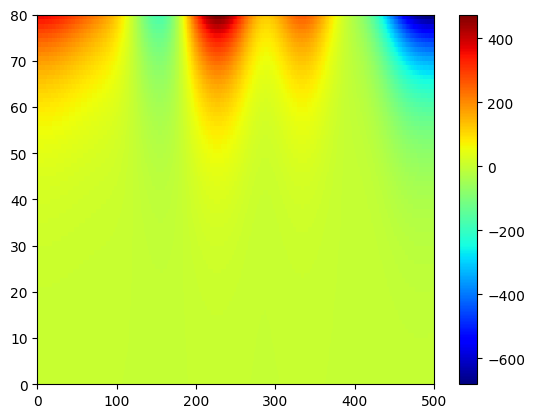

In [112]:
plt.pcolormesh(target[1], cmap = 'jet')
plt.colorbar()

In [114]:
trunk = database.trunk
trunk

array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.0080160e-02],
       [0.0000000e+00, 8.0160320e-02],
       ...,
       [7.9000000e+01, 1.9919840e+01],
       [7.9000000e+01, 1.9959919e+01],
       [7.9000000e+01, 2.0000000e+01]], shape=(40000, 2), dtype=float32)

In [ ]:
x[::5]

(100,)